In [1]:
import os
import random
import pandas as pd

In [2]:
data_dir = "/data/fmri/data"

In [19]:
def get_bin_class(score):
    if score < 10:
        return 0
    elif score >= 10 and score < 20:
        return 1
    elif score >= 20 and score < 40:
        return 2
    elif score >= 40 and score < 60:
        return 3
    elif score >= 60 and score < 80:
        return 4
    else:
        return 5

In [20]:
def get_score(sub_path, img_name):
    sess_id = img_name.split(".scale")[0][-1]
    n_back = img_name[0]
    file_path = os.path.join(sub_path, f"{n_back}back_VAS-f.1D")
    with open(file_path, "r") as label_file:
        scores = label_file.readlines()
        try:
            return int(scores[int(sess_id)].replace("\n", "")), sess_id, n_back
        except IndexError:
            return None

In [21]:
def paths_to_csv(subs):
    table = [] # with columns ["img_path", "sub_id", "group", "score"]
    for group in subs:
        for sub_id in subs[group]:
            sub = f"sub-{group}{str(sub_id).zfill(3)}"
            sub_path = os.path.join(data_dir, sub)
            for img_name in os.listdir(os.path.join(sub_path, f"{sub}.preproc")):
                if "nii.gz" not in img_name:
                    continue
                img_path = os.path.join(sub_path, f"{sub}.preproc", img_name)
                score, sess_id, n_back = get_score(sub_path, img_name)
                table.append([img_path, sub_id, sess_id, n_back, group, score, get_bin_class(score)])

    table_df = pd.DataFrame(table)
    table_df.columns = ["img_path", "sub_id", "sess_id", "n_back", "group", "score", "bin_class"]
    return table_df

In [22]:
hc_subs = [1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 16, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 33, 34]
tbi_subs = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 29, 30, 34, 35, 36]
subs = {"hc": hc_subs, "tbi": tbi_subs}

In [25]:
paths = paths_to_csv(subs)
paths.head()

,img_path,sub_id,sess_id,n_back,group,score,bin_class
0,/data/fmri/data/sub-hc001/sub-hc001.preproc/0b...,1,4,0,hc,30,2
1,/data/fmri/data/sub-hc001/sub-hc001.preproc/0b...,1,2,0,hc,25,2
2,/data/fmri/data/sub-hc001/sub-hc001.preproc/0b...,1,3,0,hc,30,2
3,/data/fmri/data/sub-hc001/sub-hc001.preproc/0b...,1,1,0,hc,25,2
4,/data/fmri/data/sub-hc001/sub-hc001.preproc/2b...,1,4,2,hc,20,2


In [24]:
paths.to_csv("fmri_img_paths.csv")

## Scores Visualization and Analysis

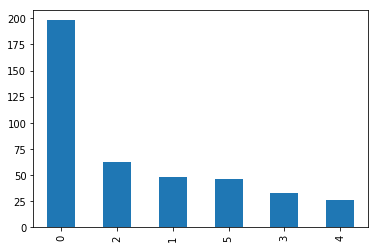

In [26]:
paths['bin_class'].value_counts().plot.bar()

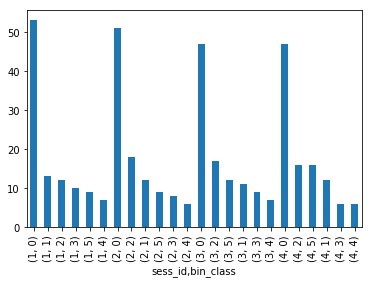

In [28]:
paths.groupby(by=["sess_id"])['bin_class'].value_counts().plot.bar()

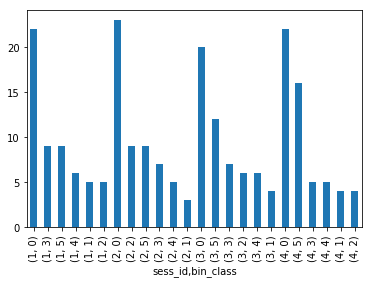

In [36]:
paths[paths["group"]=="tbi"].groupby(by=["sess_id"])['bin_class'].value_counts().plot.bar()

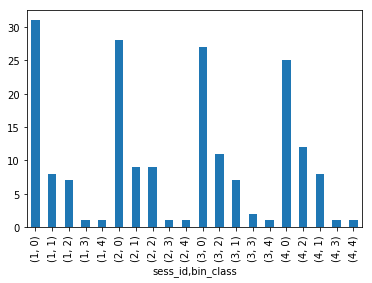

In [37]:
paths[paths["group"]=="hc"].groupby(by=["sess_id"])['bin_class'].value_counts().plot.bar()

In [5]:
def get_counts(val_pct):
    hc_subs = [1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 16, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 33, 34]
    tbi_subs = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 29, 30, 34, 35, 36]
    
    val_hc_count = int(len(hc_subs)*val_pct)
    val_tbi_count = int(len(tbi_subs)*val_pct)
    hc_val = random.sample(hc_subs, val_hc_count)
    tbi_val = random.sample(tbi_subs, val_tbi_count)
    hc_train = list(set(hc_subs) - set(hc_val))
    tbi_train = list(set(tbi_subs) - set(tbi_val))
    
    return hc_train, hc_val, tbi_train, tbi_val

def split_train_val(val_pct=0.2):
    hc_train, hc_val, tbi_train, tbi_val = get_counts(val_pct)
    train_subs, val_subs = [], []
    for tr in hc_train:
        train_subs.append(f'sub-hc{tr:03}')
    for tr in tbi_train:
        train_subs.append(f'sub-tbi{tr:03}')
    for tst in hc_val:
        val_subs.append(f'sub-hc{tst:03}')
    for tst in tbi_val:
        val_subs.append(f'sub-tbi{tst:03}')

    return train_subs, val_subs

In [3]:
def get_score(sub_path, img_name):
    sess_id = img_name.split(".scale")[0][-1]
    n_back = img_name[0]
    file_path = os.path.join(sub_path, f"{n_back}back_VAS-f.1D")
    with open(file_path, "r") as label_file:
        scores = label_file.readlines()
        try:
            return scores[int(sess_id)]
        except IndexError:
            return None

In [4]:
def prep_path_labels(subs):
    img_paths, labels = [], []
    for sub in subs:
        sub_path = os.path.join(data_dir, sub)
        for img_name in os.listdir(os.path.join(sub_path, f"{sub}.preproc")):
            if "nii.gz" not in img_name:
                continue
            img_path = os.path.join(sub_path, f"{sub}.preproc", img_name)
            label = get_score(sub_path, img_name)
            if label is None:
                continue

            img_paths.append(img_path)
            labels.append(int(label))
            
    return img_paths, labels

In [19]:
train_subs, val_subs = split_train_val(val_pct=0.2)

In [20]:
val_subs

['sub-hc022',
 'sub-hc002',
 'sub-hc003',
 'sub-hc033',
 'sub-tbi004',
 'sub-tbi011',
 'sub-tbi019',
 'sub-tbi014',
 'sub-tbi036']

In [21]:
val_img_paths, val_labels = prep_path_labels(val_subs)

In [22]:
val_img_paths[:10]

['/data/fmri/data/sub-hc022/sub-hc022.preproc/2back.r02.scale.nii.gz',
 '/data/fmri/data/sub-hc022/sub-hc022.preproc/2back.r03.scale.nii.gz',
 '/data/fmri/data/sub-hc022/sub-hc022.preproc/2back.r01.scale.nii.gz',
 '/data/fmri/data/sub-hc022/sub-hc022.preproc/2back.r04.scale.nii.gz',
 '/data/fmri/data/sub-hc022/sub-hc022.preproc/0back.r01.scale.nii.gz',
 '/data/fmri/data/sub-hc022/sub-hc022.preproc/0back.r03.scale.nii.gz',
 '/data/fmri/data/sub-hc022/sub-hc022.preproc/0back.r02.scale.nii.gz',
 '/data/fmri/data/sub-hc022/sub-hc022.preproc/0back.r04.scale.nii.gz',
 '/data/fmri/data/sub-hc002/sub-hc002.preproc/0back.r04.scale.nii.gz',
 '/data/fmri/data/sub-hc002/sub-hc002.preproc/0back.r01.scale.nii.gz']

In [23]:
val_labels[:10]

[5, 5, 5, 5, 5, 5, 5, 5, 30, 30]

In [24]:
import pandas as pd

In [25]:
train_img_paths, train_labels = prep_path_labels(train_subs)
val_img_paths, val_labels = prep_path_labels(val_subs)

In [28]:
train_data = pd.DataFrame(list(zip(train_img_paths, train_labels)))
val_data = pd.DataFrame(list(zip(val_img_paths, val_labels)))

In [29]:
train_data

,0,1
0,/data/fmri/data/sub-hc001/sub-hc001.preproc/0b...,30
1,/data/fmri/data/sub-hc001/sub-hc001.preproc/0b...,25
2,/data/fmri/data/sub-hc001/sub-hc001.preproc/0b...,30
3,/data/fmri/data/sub-hc001/sub-hc001.preproc/0b...,25
4,/data/fmri/data/sub-hc001/sub-hc001.preproc/2b...,20
5,/data/fmri/data/sub-hc001/sub-hc001.preproc/2b...,15
6,/data/fmri/data/sub-hc001/sub-hc001.preproc/2b...,10
7,/data/fmri/data/sub-hc001/sub-hc001.preproc/2b...,15
8,/data/fmri/data/sub-hc004/sub-hc004.preproc/2b...,0
9,/data/fmri/data/sub-hc004/sub-hc004.preproc/2b...,0


In [30]:
val_data

,0,1
0,/data/fmri/data/sub-hc022/sub-hc022.preproc/2b...,5
1,/data/fmri/data/sub-hc022/sub-hc022.preproc/2b...,5
2,/data/fmri/data/sub-hc022/sub-hc022.preproc/2b...,5
3,/data/fmri/data/sub-hc022/sub-hc022.preproc/2b...,5
4,/data/fmri/data/sub-hc022/sub-hc022.preproc/0b...,5
5,/data/fmri/data/sub-hc022/sub-hc022.preproc/0b...,5
6,/data/fmri/data/sub-hc022/sub-hc022.preproc/0b...,5
7,/data/fmri/data/sub-hc022/sub-hc022.preproc/0b...,5
8,/data/fmri/data/sub-hc002/sub-hc002.preproc/0b...,30
9,/data/fmri/data/sub-hc002/sub-hc002.preproc/0b...,30
